# Preloading

In [1]:
import patsy
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from ast import literal_eval
from dateutil.parser import parse
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

def log(series):
    return np.log(series+1)

# Load data 

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=4) 

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [3]:
print(X_train.shape, X_val.shape, X_test.shape)

(7873, 129) (2625, 129) (2628, 129)


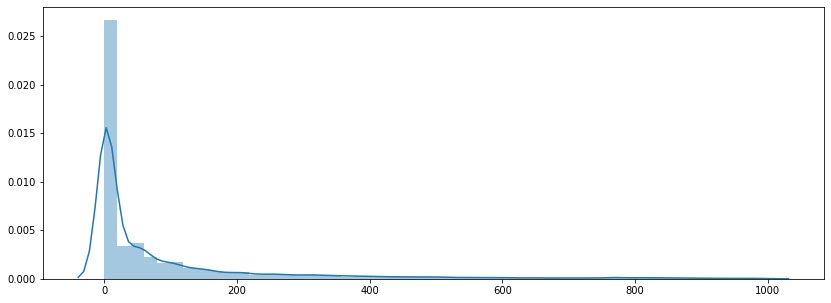

In [4]:
plt.figure(figsize=(14,5))
sns.distplot(y_train);

In [5]:
scaler = StandardScaler()
model_features = set(X_train.select_dtypes(np.number).columns) - set(['year','month','day', 'day_of_week'])
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[model_features]), columns=model_features)
X_val_scaled = pd.DataFrame(scaler.fit_transform(X_val[model_features]), columns=model_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[model_features]), columns=model_features)

# Baseline models

## (1) Naive model 

Predict using just the mean

In [6]:
naive_pred = pd.Series(np.mean(y_train)).repeat(len(y_val))
mean_absolute_error(y_val, naive_pred)

114.68350918449433

Has a mean absolute error of 113 just from predicting with a naive guess.

## (2) Lasso regression

Choose penalty coefficient

In [8]:
lasso_alphas = 10**np.linspace(-5,0,1000)
lasso_cv = LassoCV(alphas = lasso_alphas, cv=5)
lasso_cv.fit(X_train_scaled, log(y_train))
lasso_cv.alpha_

/Users/collindching/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.009727203192450537

Make predictions

In [9]:
np.random.seed(4)
lasso = Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X_train_scaled, log(y_train))
y_val_pred_lasso = np.exp(lasso.predict(X_val_scaled))
lasso_mae = mean_absolute_error(y_val, y_val_pred_lasso)
lasso_mae

79.34507269784531

## (3) Ridge  regression

Choose penalty coefficient

In [10]:
np.random.seed(4)
ridge_alphas = 10**np.linspace(0,4,200)
ridge_cv = RidgeCV(ridge_alphas, cv=5)
ridge_cv.fit(X_train_scaled, log(y_train))
ridge_cv.alpha_

517.092024289676

In [11]:
ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X_train_scaled, log(y_train))
y_val_pred_ridge = np.exp(ridge.predict(X_val_scaled))
ridge_mae = mean_absolute_error(y_val, y_val_pred_ridge)
ridge_mae

79.54458881452119

Check feature importances

## (4) ElasticNet

Choose penalty coefficient

In [12]:
np.random.seed(4)
en_alpha = 10**np.linspace(-5,0,100)
en_lambda = np.linspace(0 + 1/200,1,100)
en_cv = ElasticNetCV(l1_ratio = en_lambda, n_alphas = 100, cv=5)
en_cv.fit(X_train_scaled, log(y_train).values.ravel());

In [13]:
print(en_cv.alpha_)

0.04349603712970927


In [14]:
print(en_cv.l1_ratio_)

0.16580808080808082


In [21]:
en = ElasticNet(en_cv.alpha_, en_cv.l1_ratio_)
en.fit(X_train_scaled, log(y_train))
y_val_pred_en = np.exp(en.predict(X_val_scaled))
en_mae = mean_absolute_error(y_val, y_val_pred_en)
en_mae

79.42690374495434

Check feature importances

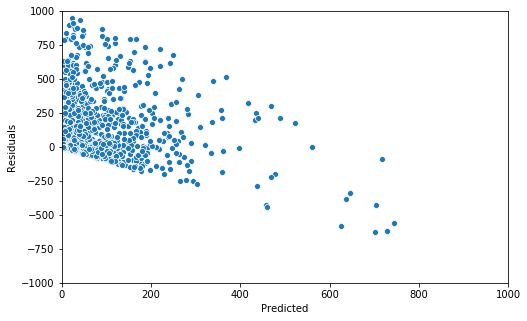

In [22]:
plt.figure(figsize=(8,5))
en_residuals = y_val.values.flatten() - y_val_pred_en
sns.scatterplot(y_val_pred_en, en_residuals)
plt.xlim(0,1000)
plt.ylim(-1000,1000)
plt.ylabel('Residuals');
plt.xlabel('Predicted');
plt.savefig('en_residuals.png')

This plot suggests that claps do not have a linear relationship with the beta coefficients of my model. The most glaring clue is that the slope of the residuals is negative, a violation of the OLS assumption of errors having zero conditional mean. 

At this point, there are a few ways to achieve better residuals: either improve the quality of data inputs or try more apt models. Some options to consider:

- **Transform the independent variables:** I used a Yeo-Johnson transformation to improve normality, but this did not improve the linearity between my coefficients and the outcome. 
- **Use a tree regression:** I modeled a random forest on the data, which makes no assumptions about the data distribution. Unfortunately, this performed slightly worse than my elastic net models. But at the very least, I'm not violating any assumptions.
- **Add better features (polynomial, NLP):** I suspect that extracting more meaningful features, like through topic modeling, would have the most significant effect on decreasing bias. Unfortunately, polynomial and NLP feature engineering are beyond the scope of this project for me.



## (5) Random Forest 

Use random forest to circumvent linearity assumption. Lose interpretation of beta coefficients, but model is valid. 

#### Tune

In [23]:
params = {
    'max_depth': [10, 12, 14, 16],
    'max_features': [20, 30, 40, 50],
    'min_samples_leaf' : [2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

gridsearch = GridSearchCV(
    RandomForestRegressor(n_estimators=100),
    cv=5,
    param_grid=params,
    n_jobs=4,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

gridsearch.fit(X_train[model_features],y_train.values.ravel())

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  7.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [10, 12, 14, 16],
      

In [24]:
rf = gridsearch.best_estimator_
#rf.set_params(**{'n_estimators':200})

In [28]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features=40, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### Predict

#### Validation

In [35]:
# validation predictions
rf.fit(X_train[model_features], y_train.values.ravel())
y_val_pred_rf = rf.predict(X_val[model_features])
final_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
print(f"Validation MAE is {round(final_val_mae,2)}.")

# test predictions
y_test_pred_rf = rf.predict(X_test[model_features])
final_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
print(f"Test MAE is {round(final_test_mae,2)}.")

Validation MAE is 85.47.
Test MAE is 82.5.


#### Save ([pickle](https://scikit-learn.org/stable/modules/model_persistence.html))

In [26]:
from joblib import dump, load
dump(rf, 'rf_final.pkl') 

['rf_final.pkl']